# Data loading 
Next cells are used to load the data we need.

In [1]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')


In [2]:
#data which contains users (row), items(col) and implicit interaction (data)
#dataset = pd.read_csv('data_train.csv')
dataset = pd.read_csv('data_train.csv', names=["user", "item", "interaction"], header=0)
dataset

,user,item,interaction
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


# Data pre-processing
Pre-processing of data to check for missing users, items ecc...

In [3]:
def list_ID_stats(ID_list, label):
    
    min_val = min(ID_list)
    max_val = max(ID_list)
    unique_val = len(set(ID_list))
    missing_val = 1 - unique_val/(max_val - min_val)

    print("{} data, ID: min {}, max {}, unique {}, missig {:.2f} %".format(label, min_val, max_val, unique_val, missing_val*100))

list_ID_stats(dataset.user, "User")
list_ID_stats(dataset.item, "Item")

User data, ID: min 0, max 7946, unique 7947, missig -0.01 %
Item data, ID: min 0, max 25974, unique 24896, missig 4.15 %


If the difference between the unique elements and the max/min ones is really big, it's better to remap users and items in a new dataframe. In this case, it seems I can leave it as it is

In [4]:
users = dataset.user
items = dataset.item
interaction = dataset.interaction
URM_all = sps.coo_matrix((interaction, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

In [9]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

#splitting data into train and test. In teoria non serve, da vedere
#URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)

#splitting data into train and validation (from the previous training data)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)



In [10]:
#evaluator for validation (used for hyperparameter tuning)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

#evaluator for testing (the final one)
#evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

In [11]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

recommender = ItemKNNCFRecommender(URM_train)

ItemKNNCFRecommender: URM Detected 42 (0.53 %) cold users.
ItemKNNCFRecommender: URM Detected 1970 (7.58 %) cold items.


In [22]:
x_tick = []
collaborative_MAP = []
maxMAP = 0
maxXTick = ""
for topK in [50,100,150,200,250,300,350,400,450,480,500,520,550,580,600]:
    for shrink in [0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750]:
        
        x_tick.append("topk {}, shrink {}".format(topK, shrink))

        
        recommender = ItemKNNCFRecommender(URM_train)
        recommender.fit(shrink=shrink, topK=topK, feature_weighting = "BM25")
    
        result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

        collaborative_MAP.append(result_dict[10]["MAP"])

nder: URM Detected 42 (0.53 %) cold users.
ItemKNNCFRecommender: URM Detected 1970 (7.58 %) cold items.
Similarity column 25975 ( 100 % ), 7148.84 column/sec, elapsed time 0.06 min
EvaluatorHoldout: Processed 4966 ( 100.00% ) in 3.43 sec. Users per second: 1449
ItemKNNCFRecommender: URM Detected 42 (0.53 %) cold users.
ItemKNNCFRecommender: URM Detected 1970 (7.58 %) cold items.
Similarity column 25975 ( 100 % ), 7175.51 column/sec, elapsed time 0.06 min
EvaluatorHoldout: Processed 4966 ( 100.00% ) in 3.42 sec. Users per second: 1453
ItemKNNCFRecommender: URM Detected 42 (0.53 %) cold users.
ItemKNNCFRecommender: URM Detected 1970 (7.58 %) cold items.
Similarity column 25975 ( 100 % ), 7228.26 column/sec, elapsed time 0.06 min
EvaluatorHoldout: Processed 4966 ( 100.00% ) in 3.46 sec. Users per second: 1436
ItemKNNCFRecommender: URM Detected 42 (0.53 %) cold users.
ItemKNNCFRecommender: URM Detected 1970 (7.58 %) cold items.
Similarity column 25975 ( 100 % ), 7197.73 column/sec, elapsed

In [ ]:
import operator
index, value = max(enumerate(collaborative_MAP), key=operator.itemgetter(1))
print(index, value)
parameters = x_tick[index]
print(parameters)

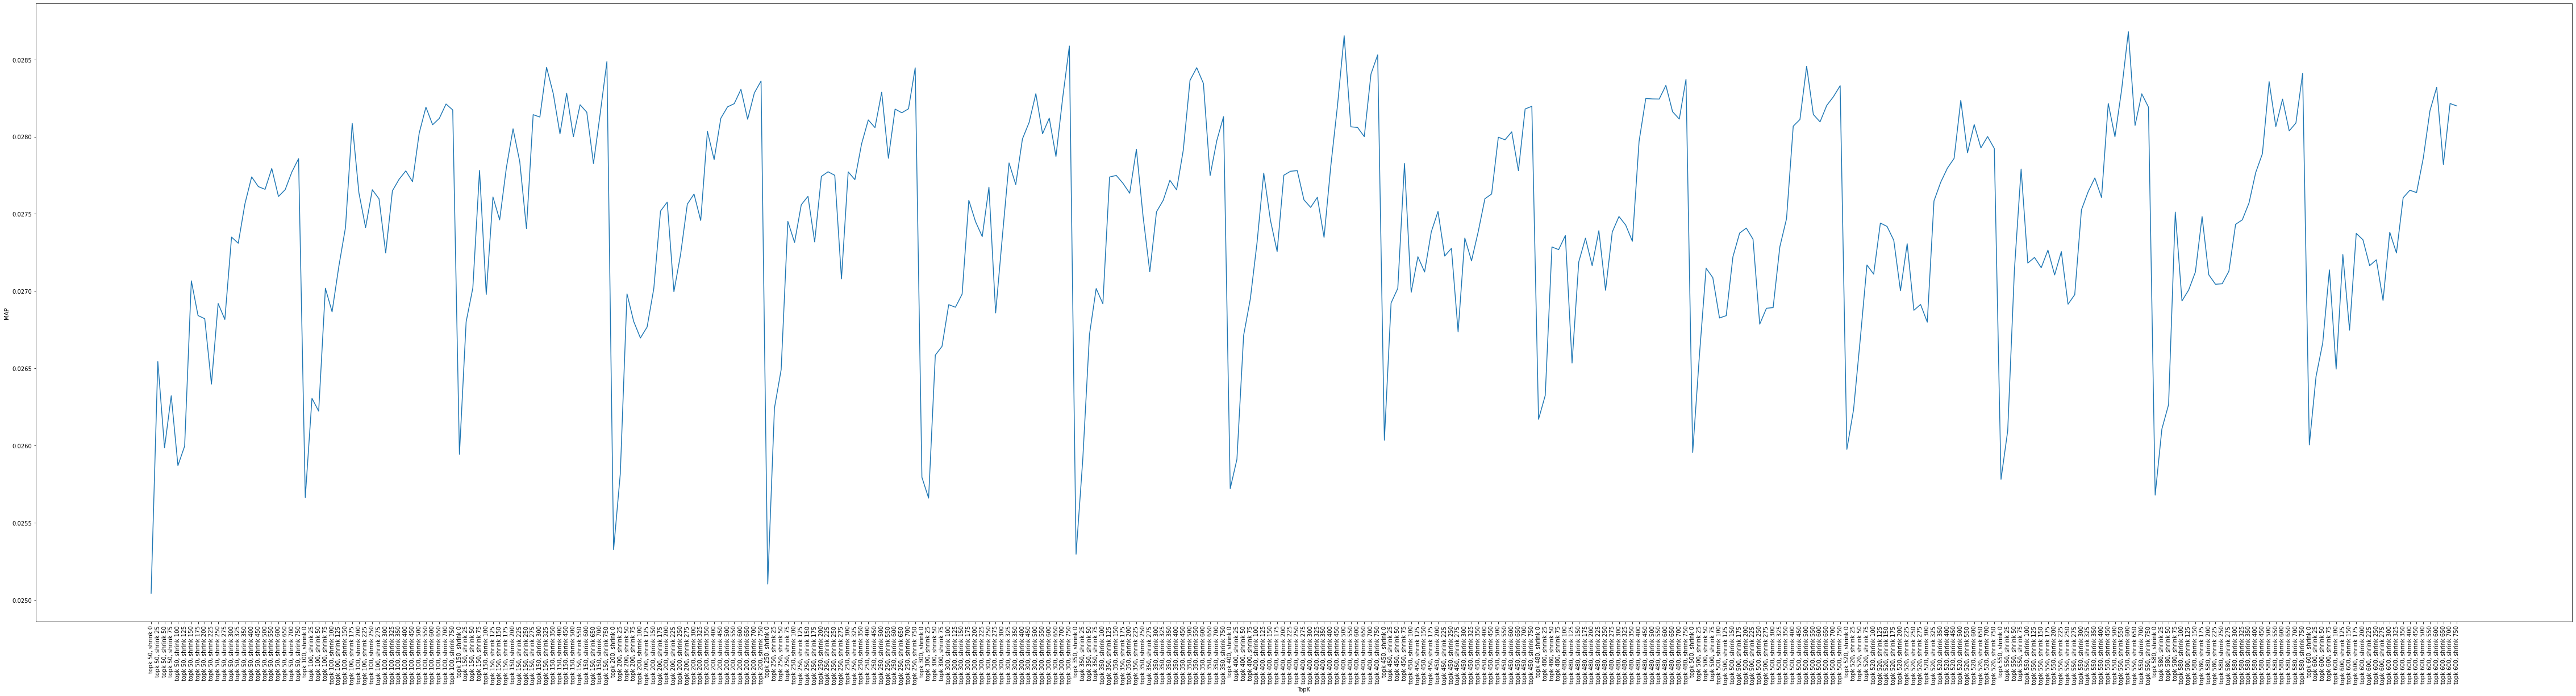

In [25]:
#best model: topk = 550, shrink = 600, TF-IDF
plt.figure(figsize=(80,20))
plt.plot(x_tick, collaborative_MAP, label="Collaborative", )
plt.ylabel('MAP')
plt.xlabel('TopK')
plt.xticks(rotation='vertical')
plt.show()

In [26]:
test_users = pd.read_csv('data_target_users_test.csv')
test_users

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
7939,7942
7940,7943
7941,7944
7942,7945


In [19]:
recommender = ItemKNNCFRecommender(URM_all)
recommender.fit(shrink=600, topK=550, feature_weighting = "BM25")

user_id = test_users['user_id']
recommendations = recommender.recommend(user_id, cutoff = 10)


ItemKNNCFRecommender: URM Detected 1079 (4.15 %) cold items.
Similarity column 25975 ( 100 % ), 6558.22 column/sec, elapsed time 0.07 min


In [20]:
for index in range(len(recommendations)):
    #print(element)
    recommendations[index]=np.array(recommendations[index])
    #print(type(element))
print(len(recommendations))

7944


In [21]:
test_users['item_list']= recommendations
#test_users['item_list'] =  test_users['item_list'].apply(lambda x: x.replace('[','').replace(']','')) 
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])

#convert the string columns to int
#test_users['item_list'] = test_users['item_list'].astype(int)
test_users
test_users.to_csv('submission.csv', index=False)
